In [20]:
from __future__ import print_function
import keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import os
from tensorflow.keras.applications import ResNet50, DenseNet121
import matplotlib.pyplot as plt

In [24]:
!rm -rf utils
!git clone https://github.com/Moeinh77/utils
from utils.tools.clr_callback import CyclicLR
from utils.tools.learningratefinder import LearningRateFinder
from sklearn.metrics import confusion_matrix
print('Tools imported!')

Cloning into 'utils'...
remote: Enumerating objects: 37, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 37 (delta 16), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (37/37), done.
Tools imported!


In [2]:
# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
num_classes = 10
# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

170500096/170498071 [==============================] - 2s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [3]:
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    zca_epsilon=1e-06,  # epsilon for ZCA whitening
    rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
    # randomly shift images horizontally (fraction of total width)
    width_shift_range=0.1,
    # randomly shift images vertically (fraction of total height)
    height_shift_range=0.1,
    shear_range=0.,  # set range for random shear
    zoom_range=0.,  # set range for random zoom
    channel_shift_range=0.,  # set range for random channel shifts
    # set mode for filling points outside the input boundaries
    fill_mode='nearest',
    cval=0.,  # value used for fill_mode = "constant"
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False,  # randomly flip images
    # set rescaling factor (applied before any other transformation)
    rescale=None,
    # set function that will be applied on each input
    preprocessing_function=None,
    # image data format, either "channels_first" or "channels_last"
    data_format=None,
    # fraction of images reserved for validation (strictly between 0 and 1)
    validation_split=0.0)

# Compute quantities required for feature-wise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)


In [39]:
batch_size = 64
the_model = 'densenet121'
in_size =32
transfer_lr = False
in_dim =3
dout = 0.
base_weights=None

# here we freeze everything except the last layer
# transfer learning make the accuracy stuck
if transfer_lr:
    base_weights= 'imagenet'#the_model+'_weights_tf_dim_ordering_tf_kernels_notop.h5'

if the_model == 'resnet50':
    base_model = ResNet50(weights=base_weights, include_top=False)#, input_shape=(in_size,in_size,in_dim))
elif the_model == 'densenet121':
#     if transfer_lr:
#         base_weights= the_model+'_weights_tf_dim_ordering_tf_kernels_notop_2.h5'
    base_model = DenseNet121(weights=base_weights, include_top=False)#, input_shape=(in_size,in_size,in_dim))
    
base_model.trainable = not transfer_lr

inputs = Input(shape=(in_size, in_size, in_dim))
    
x = base_model(inputs, training = not transfer_lr)
x = GlobalAveragePooling2D()(x) # instead of dense layer
# x = Flatten()(x)
if dout!= 0.:
    x = Dropout(dout)(x) # Regularize with dropout

activation_f = 'softmax'
# final_neurons = num_classes
final_neurons = 10

outputs = Dense(final_neurons, activation=activation_f)(x)

model = Model(inputs, outputs)

model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
densenet121 (Functional)     (None, None, None, 1024)  7037504   
_________________________________________________________________
global_average_pooling2d_4 ( (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                10250     
Total params: 7,047,754
Trainable params: 6,964,106
Non-trainable params: 83,648
_________________________________________________________________


In [41]:
monitor= 'val_accuracy'
weight_address = 'weights/'+'best_model_todate_' + the_model + '.hdf5'

opt = Adam() 
chkpt = ModelCheckpoint(filepath=weight_address, save_best_only=True,
                        save_weights_only=True, monitor=monitor, mode='max')

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

lr_track = get_lr_metric(opt)

model.compile(loss= 'categorical_crossentropy', metrics=['accuracy',lr_track], optimizer=opt)

Using generator: True
Epoch 1/5
781/781 [==============================] - 55s 58ms/step - loss: 2.9951 - accuracy: 0.1209 - lr: 1.7402e-06
Epoch 2/5
781/781 [==============================] - 45s 57ms/step - loss: 2.0391 - accuracy: 0.3130 - lr: 1.0980e-05
Epoch 3/5
781/781 [==============================] - 45s 58ms/step - loss: 1.1261 - accuracy: 0.6112 - lr: 6.9280e-05
Epoch 4/5
781/781 [==============================] - 45s 58ms/step - loss: 0.7638 - accuracy: 0.7410 - lr: 4.3713e-04
Epoch 5/5
781/781 [==============================] - 45s 57ms/step - loss: 1.3475 - accuracy: 0.5818 - lr: 0.0028


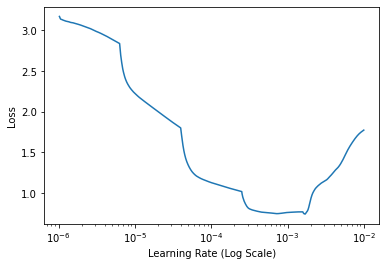

In [42]:
steps_per_epoch=len(x_train)//batch_size

lrf = LearningRateFinder(model)
lrf.find(
    datagen.flow(x_train,y_train,batch_size=batch_size),
    1e-6, 1e-2,
    stepsPerEpoch=steps_per_epoch,
    batchSize=batch_size
    ,epochs=5)

lrf.plot_loss()

In [43]:
MIN_LR = 6e-4
MAX_LR = 4e-4
STEP_SIZE = 1
CLR_METHOD = "triangular"

clr = CyclicLR(
    mode= CLR_METHOD,
    base_lr= MIN_LR,
    max_lr= MAX_LR,
    step_size= STEP_SIZE * steps_per_epoch)

In [44]:
history= []
!mkdir weights

mkdir: cannot create directory ‘weights’: File exists


In [45]:
epochs = 25

history.append(model.fit(datagen.flow(x_train, y_train,
                    batch_size=batch_size),
                    epochs=epochs,
                    validation_data=(x_test, y_test),callbacks=[chkpt, clr]))

Epoch 1/25
782/782 [==============================] - 51s 66ms/step - loss: 0.8732 - accuracy: 0.7029 - lr: 5.0000e-04 - val_loss: 0.6552 - val_accuracy: 0.7807 - val_lr: 4.0025e-04
Epoch 2/25
782/782 [==============================] - 49s 63ms/step - loss: 0.5955 - accuracy: 0.7964 - lr: 5.0026e-04 - val_loss: 0.6184 - val_accuracy: 0.7959 - val_lr: 5.9949e-04
Epoch 3/25
782/782 [==============================] - 49s 63ms/step - loss: 0.5873 - accuracy: 0.8005 - lr: 4.9949e-04 - val_loss: 0.5583 - val_accuracy: 0.8098 - val_lr: 4.0077e-04
Epoch 4/25
782/782 [==============================] - 49s 63ms/step - loss: 0.4861 - accuracy: 0.8331 - lr: 5.0076e-04 - val_loss: 1.0505 - val_accuracy: 0.6600 - val_lr: 5.9898e-04
Epoch 5/25
782/782 [==============================] - 49s 63ms/step - loss: 0.5518 - accuracy: 0.8131 - lr: 4.9898e-04 - val_loss: 0.5455 - val_accuracy: 0.8297 - val_lr: 4.0128e-04
Epoch 6/25
782/782 [==============================] - 49s 63ms/step - loss: 0.4449 - accur

In [ ]:
in 2 epochs achieved the 30 epochs of the last model

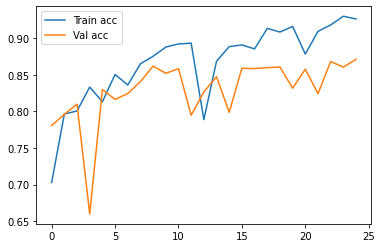

In [48]:
plt.plot(history[0].history['accuracy'])
plt.plot(history[0].history['val_accuracy'])
plt.legend(['Train acc','Val acc'])
plt.show()

In [49]:
# Load the model weights
model.load_weights(weight_address)
model.evaluate(x_test,y_test)

313/313 [==============================] - 4s 14ms/step - loss: 0.4168 - accuracy: 0.8710 - lr: 4.0640e-04


[0.41675132513046265, 0.8709999918937683, 0.0004064008535351604]

In [ ]:
# # Load the model best weights and unfreeze for fine tune
# opt = Adam()
# lr_track = get_lr_metric(opt)
# base_model.trainable = True
# model.compile(loss=loss_type, metrics=['accuracy', lr_track], optimizer=opt)
# model.summary()

Using generator: True
Epoch 1/5
781/781 [==============================] - 45s 57ms/step - loss: 0.1473 - accuracy: 0.9496 - lr: 3.9029e-08
Epoch 2/5
781/781 [==============================] - 45s 57ms/step - loss: 0.1484 - accuracy: 0.9483 - lr: 3.9029e-07
Epoch 3/5
781/781 [==============================] - 45s 58ms/step - loss: 0.1405 - accuracy: 0.9501 - lr: 3.9029e-06
Epoch 4/5
781/781 [==============================] - 45s 58ms/step - loss: 0.1203 - accuracy: 0.9588 - lr: 3.9029e-05
Epoch 5/5
781/781 [==============================] - 45s 58ms/step - loss: 0.1701 - accuracy: 0.9398 - lr: 3.9029e-04


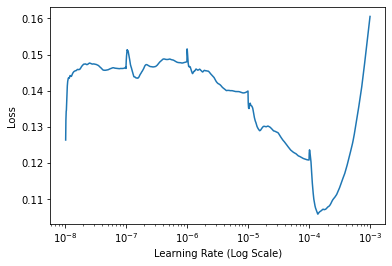

In [53]:
lrf = LearningRateFinder(model)
lrf.find(
    datagen.flow(x_train,y_train,batch_size=batch_size),
    1e-8, 1e-3,
    stepsPerEpoch=steps_per_epoch,
    batchSize=batch_size
    ,epochs=5)

lrf.plot_loss()

In [55]:
MIN_LR = 9e-5
MAX_LR = 2e-4
STEP_SIZE = 1
CLR_METHOD = "triangular"

clr = CyclicLR(
    mode= CLR_METHOD,
    base_lr= MIN_LR,
    max_lr= MAX_LR,
    step_size= STEP_SIZE * steps_per_epoch)

In [58]:
nb_epochs = 20
# Fit the model

history.append(model.fit(datagen.flow(x_train,y_train,batch_size=batch_size), 
                              epochs=nb_epochs, steps_per_epoch=steps_per_epoch,
                              validation_data=(x_test, y_test),callbacks=[chkpt, clr]))


Epoch 1/20
781/781 [==============================] - 50s 64ms/step - loss: 0.1255 - accuracy: 0.9564 - lr: 1.4493e-04 - val_loss: 0.4140 - val_accuracy: 0.8755 - val_lr: 2.0000e-04
Epoch 2/20
781/781 [==============================] - 50s 64ms/step - loss: 0.1042 - accuracy: 0.9638 - lr: 1.4507e-04 - val_loss: 0.4221 - val_accuracy: 0.8789 - val_lr: 9.0000e-05
Epoch 3/20
781/781 [==============================] - 50s 63ms/step - loss: 0.0965 - accuracy: 0.9664 - lr: 1.4493e-04 - val_loss: 0.4326 - val_accuracy: 0.8790 - val_lr: 2.0000e-04
Epoch 4/20
781/781 [==============================] - 50s 64ms/step - loss: 0.0841 - accuracy: 0.9707 - lr: 1.4507e-04 - val_loss: 0.4448 - val_accuracy: 0.8798 - val_lr: 9.0000e-05
Epoch 5/20
781/781 [==============================] - 50s 64ms/step - loss: 0.0758 - accuracy: 0.9732 - lr: 1.4493e-04 - val_loss: 0.4774 - val_accuracy: 0.8761 - val_lr: 2.0000e-04
Epoch 6/20
781/781 [==============================] - 50s 64ms/step - loss: 0.0704 - accur

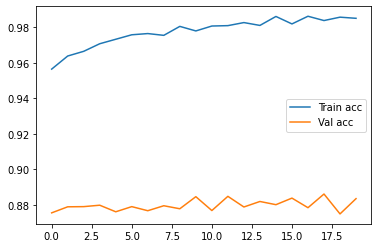

In [60]:
plt.plot(history[1].history['accuracy'])
plt.plot(history[1].history['val_accuracy'])
plt.legend(['Train acc','Val acc'])
plt.show()

In [61]:
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /content/saved_models/keras_cifar10_trained_model.h5 


In [62]:
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

313/313 [==============================] - 4s 14ms/step - loss: 0.5305 - accuracy: 0.8835 - lr: 9.0000e-05
Test loss: 0.5305074453353882
Test accuracy: 0.8834999799728394
